Test Area Under ROC: 0.9809687060478199


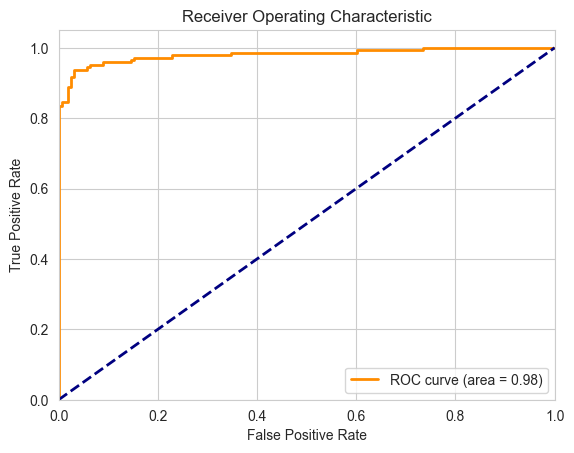

[[152   6]
 [  9 135]]


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

# Initialize Spark Session
spark = SparkSession.builder.appName("CreditCardFraudDetection").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Read and set the dataset
df = spark.read.csv('creditcard.csv',
                    inferSchema=True,
                    header=True)

input_cols = df.columns
input_cols.remove('Class')

# Data preprocessing
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df = assembler.transform(df)

# Undersampling
fraud_df = df.filter(col('Class') == 1)
non_fraud_df = df.filter(col('Class') == 0)
sampled_non_fraud_df = non_fraud_df.sample(False, fraud_df.count()/non_fraud_df.count())
balanced_df = fraud_df.unionAll(sampled_non_fraud_df)

# Split the data
train, test = balanced_df.randomSplit([0.7, 0.3], seed=20000217)

# Set up logistic regression
lr = LogisticRegression(featuresCol='features', labelCol='Class')

# Train the model
lr_model = lr.fit(train)

# Make predictions
predictions = lr_model.transform(test)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='Class')
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

# Plot the AUC
predictions_pd = predictions.select('Class', 'probability').toPandas()
predictions_pd['probability'] = predictions_pd['probability'].apply(lambda x: x[1])

fpr, tpr, thresholds = roc_curve(predictions_pd['Class'], predictions_pd['probability'])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculating the confusion matrix
y_true = predictions_pd['Class']
y_pred = predictions_pd['probability'].apply(lambda x: 1 if x >= 0.5 else 0)
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
